In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics import Accuracy
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm.autonotebook import tqdm

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=.20)
print(Counter(y))
print(X.shape)

Counter({np.int64(1): 5000, np.int64(0): 5000})
(10000, 2)


Баланс классов: 5000 примеров с "1", 5000 примеров с "0"

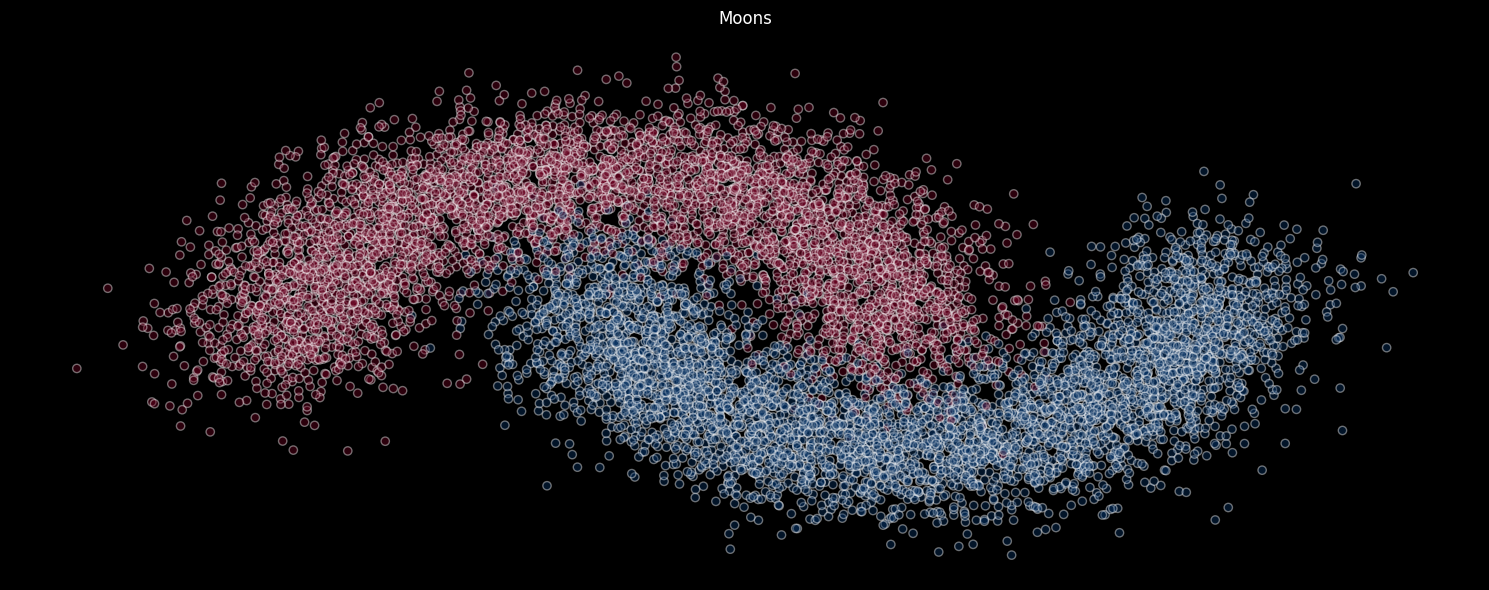

In [ ]:
# Визуализация данных
plt.figure(figsize=(15,6))
plt.title("Moons")
plt.scatter(X[:, 0], X[:, 1], 
            c=y, cmap="RdBu",
            alpha=.42,
            ec='white')
plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.3)
train_X = torch.from_numpy(X_train).to(torch.float32)
train_y = torch.from_numpy(y_train).to(torch.int32)
val_X = torch.from_numpy(X_val).to(torch.float32)
val_y = torch.from_numpy(y_val).to(torch.int32)
print(type(train_X), type(train_y), type(val_X), type(val_y))


<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


Подготовка данных для PyTorch

In [8]:
# Create Datasets
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)

# Create batch loader
BATCH = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH)
val_loader = DataLoader(val_dataset, batch_size=BATCH)

**Линейная модель**

In [5]:
class MyLinearRegression(nn.Module):
    # 1-ый обязательный метод
    def __init__(self, in_feautres, out_features): # сколко данных на вход и на выход
        super().__init__() # обязательно, чтобы передать наш инит в nn.module
        # self.W = torch.randn((in_feautres, out_features), requires_grad=True) 
        # определяем веса размером in_f и out_f, веса на первом слое задаем норм. распред. Requires grad нужен для подсчета весов
        # однако в виде написаном выше он не заработает. Чтобы модель поняла, что это слой, добавим nn.Parameter:
        self.W = nn.Parameter(torch.randn((in_feautres, out_features), requires_grad=True))
        self.b = nn.Parameter(torch.ones((out_features), requires_grad=True))

    # 2-ой обязательный метод
    def forward(self, x): # прямой проход по модели
        x = x @ self.W
        x += self.b
        return x

**Обучение**

Исходные данные перед созданием цикла

In [6]:
# 1) Задать модель
model = MyLinearRegression(2, 1) # два признака (х1 и х2), один результат на выходе
# 2) Задать функцию потерь
loss_function = nn.BCEWithLogitsLoss() # у нас бинарная классифиакция, поэтому BCE (бинарная крос энтропия). BCELoss применяется если мы проводили данные через сигмоиду (мы так не делали). Поэтому юзаем BCEWithLogistLoss
# 3) Задать оптимизатор
optimizer = torch.optim.SGD(model.parameters(), lr=.042) # градиентный спуск. !Всегда указываем model.parameters(), а потом learning rate
# 4) Перенести модель на GPU (не делаем, у меня нет CUDA)
# 5) Задать метрику
accuracy = Accuracy(task='binary')

# Плюс построения модели с nn в том, что лего собирать инфу с каждой итерации (итерация - прогон батча, эпоха - прогон датасета)
losses_train = [] # лосс на каждой итерации
total_loss = [] # общий лосс
acc_val = [] # accuracy на валидации
# Тут я просто создал показатели по которым буду смотреть как работает модель

# 6) Задаем общее кол-во эпох
MAX_EPOCHS = 100

Строим цикл

In [9]:
# для каждой эпохи
for epochs in tqdm(range(MAX_EPOCHS)):
    # для каждой итерации
    for iteration, (X_batch, y_batch) in enumerate(train_loader):
        # ЭТАП ОБУЧЕНИЯ
        model.train() # обучили модель
        optimizer.zero_grad() # обнулить градииенты. Это делаем до прямого прохода
        outputs = model(X_batch) # пропускаем данные через модель (вызвали forward)
        outputs = outputs.view(-1) # выравниваем выходы в одномерный тензор
        loss = loss_function(outputs, y_batch.float()) # считаем лосс
        loss.backward() # обратное распространение ошибки (считаем веса)
        losses_train.append(loss.detach().numpy().item()) # прицепили значение функции потерь в ранее созданный список. detach отцепил от тензора, перевели в нумпи, получили число
        optimizer.step() # все этапы прошли, делай следующий шаг
    total_loss.append(np.mean(losses_train)) # стоимость эпохи
    # ВАЛИДАЦИЯ
    for iteration, (X_batch, y_batch) in enumerate(val_loader):
        model.eval() # режим для валидации
        with torch.no_grad(): # говорим чтобы без градиентов, т.к. все уже посчитано
            outputs = model(X_batch)
            outputs = outputs.view(-1)
            loss = loss_function(outputs, y_batch.float())
            proba = torch.sigmoid(outputs) # получили вероятности
            # считаем метрику
            batch_acc = accuracy(proba, y_batch.to(torch.int32))
            acc_val.append(batch_acc.detach().numpy().item())

  0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
acc = np.mean(acc_val)
print(f'Accuracy линейной модели: {acc:.2%}')

Accuracy линейной модели: 87.32%


Графики для наших ранее созданных списков

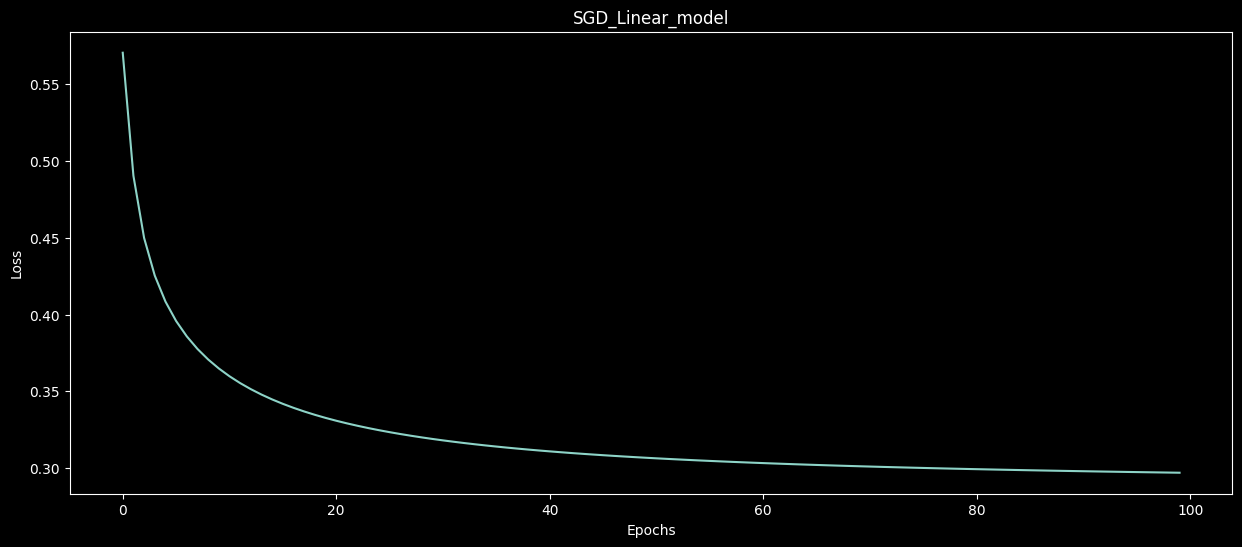

In [11]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(total_loss)), total_loss, linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('SGD_Linear_model')
plt.show()

**НЕЙРОНКА**

In [12]:
class LinearNeuron(nn.Module):
    def __init__(self, in_feautures, out_features):
        super().__init__()
        self.linear_1 = self.make_layer(in_feautures, in_feautures*8)
        self.linear_2 = self.make_layer(in_feautures*8, in_feautures*4)
        self.linear_3 = self.make_layer(in_feautures*4, out_features)
        self.relu = F.relu
        
    def make_layer(self, in_f, out_f):
        return nn.Linear(in_f, out_f)
        
    def forward(self, x):
        x = self.linear_1(x)
        x = self.relu(x) # ReLU - все значения меньше 0 превращает в 0
        x = self.linear_2(x)
        x = self.relu(x)
        x = self.linear_3(x)
        return x

In [13]:
model = LinearNeuron(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.05)

losses_train = []
losses_val = []
total_train_loss = []
total_val_loss = []
acc_val = []

MAX_EPOCHS = 100

In [14]:
for epoch in tqdm(range(MAX_EPOCHS)):
    for iter, (X_batch, y_batch) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_batch)
        outputs = outputs.view(-1)
        loss = loss_function(outputs, y_batch.float())
        loss.backward()
        losses_train.append(loss.detach().numpy().item())
        optimizer.step()
    total_train_loss.append(np.mean(losses_train))
    for iter, (X_batch, y_batch) in enumerate(val_loader):
        model.eval()
        with torch.no_grad():
            outputs = model(X_batch)
            outputs = outputs.view(-1)
            loss = loss_function(outputs, y_batch.float())
            losses_val.append(loss.detach().numpy().item())
            proba = torch.sigmoid(outputs)
            batch_acc = accuracy(proba, y_batch.to(torch.int32))
            acc_val.append(batch_acc.detach().numpy().item())
    total_val_loss.append(np.mean(losses_val))

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
acc = np.mean(acc_val)
print(f'Accuracy нейронной модели: {acc:.2%}')

Accuracy нейронной модели: 96.81%


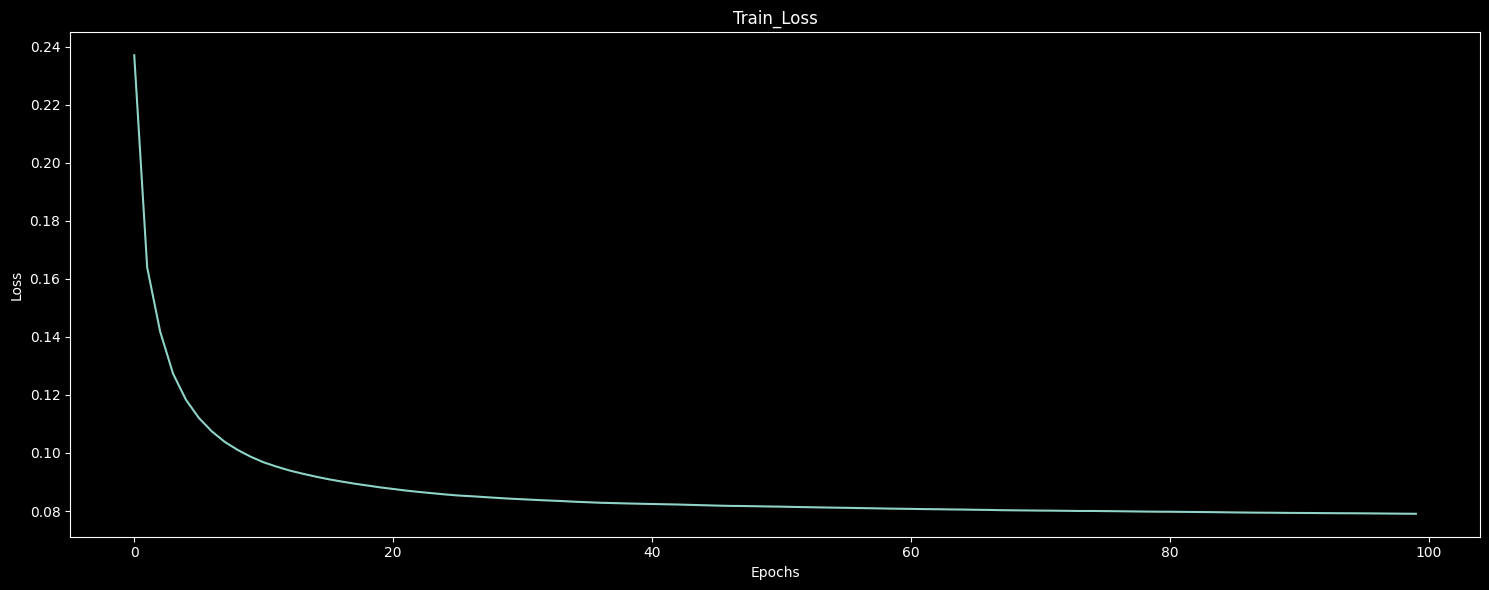

In [17]:
plt.figure(figsize=(15, 6))
plt.plot(range(MAX_EPOCHS), total_train_loss, linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train_Loss')
plt.tight_layout()
plt.show()

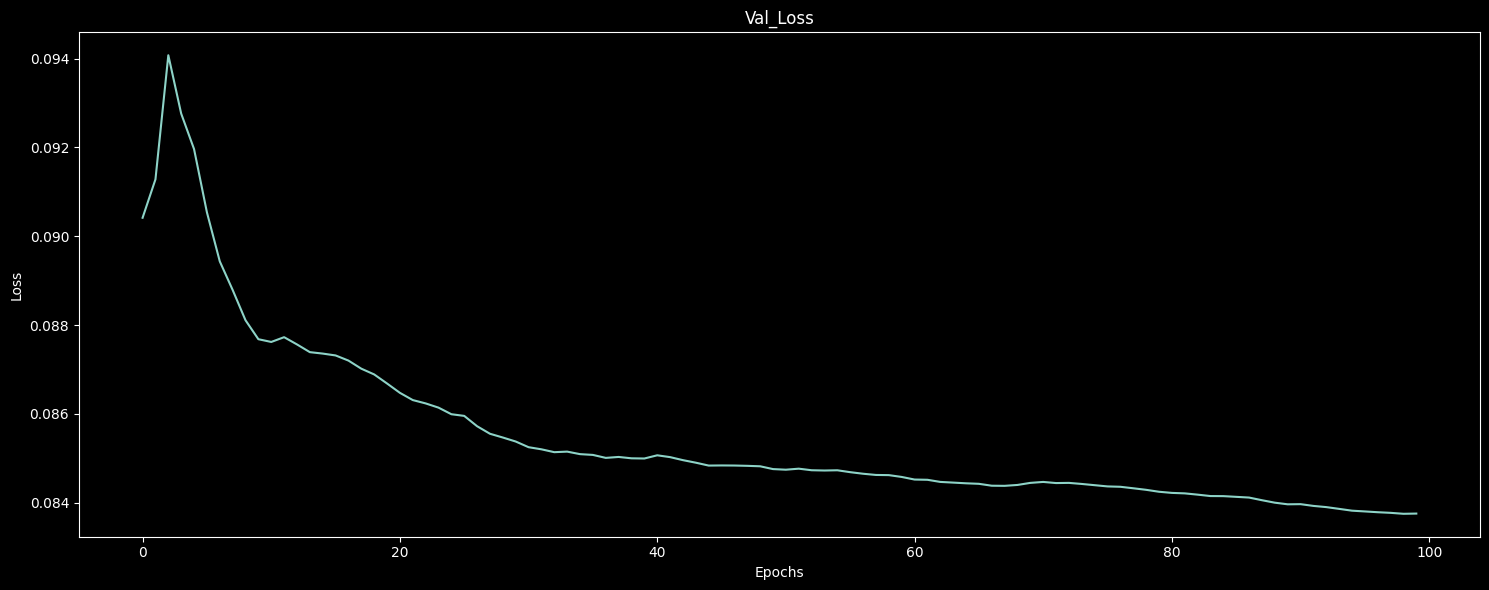

In [18]:
plt.figure(figsize=(15, 6))
plt.plot(range(MAX_EPOCHS), total_val_loss, linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Val_Loss')
plt.tight_layout()
plt.show()

In [19]:
def plot_decision_boundary(model: nn.Module) -> None:
    # установим минимальные и максимальные значения и добавим паддинг (отступы)
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.1
    # сгенерируем сетку точек, с расстоянием h между ними
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # предскажем
    model.eval() # переводим модель в режим инференса
    with torch.no_grad(): # градиент не считаем
      data = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float32)
      probs = torch.sigmoid(model(data).reshape(xx.shape))
      probs = probs.numpy().reshape(xx.shape)

    # отрисуем точки
    plt.figure(figsize=(15, 6))
    plt.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
    plt.scatter(X[100:, 0], X[100:, 1], 
                c=y[100:], 
                cmap="RdBu", 
                s=50, 
                linewidth=1,
                alpha=.42, 
                ec="black")
    plt.title("Decision Boundary")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

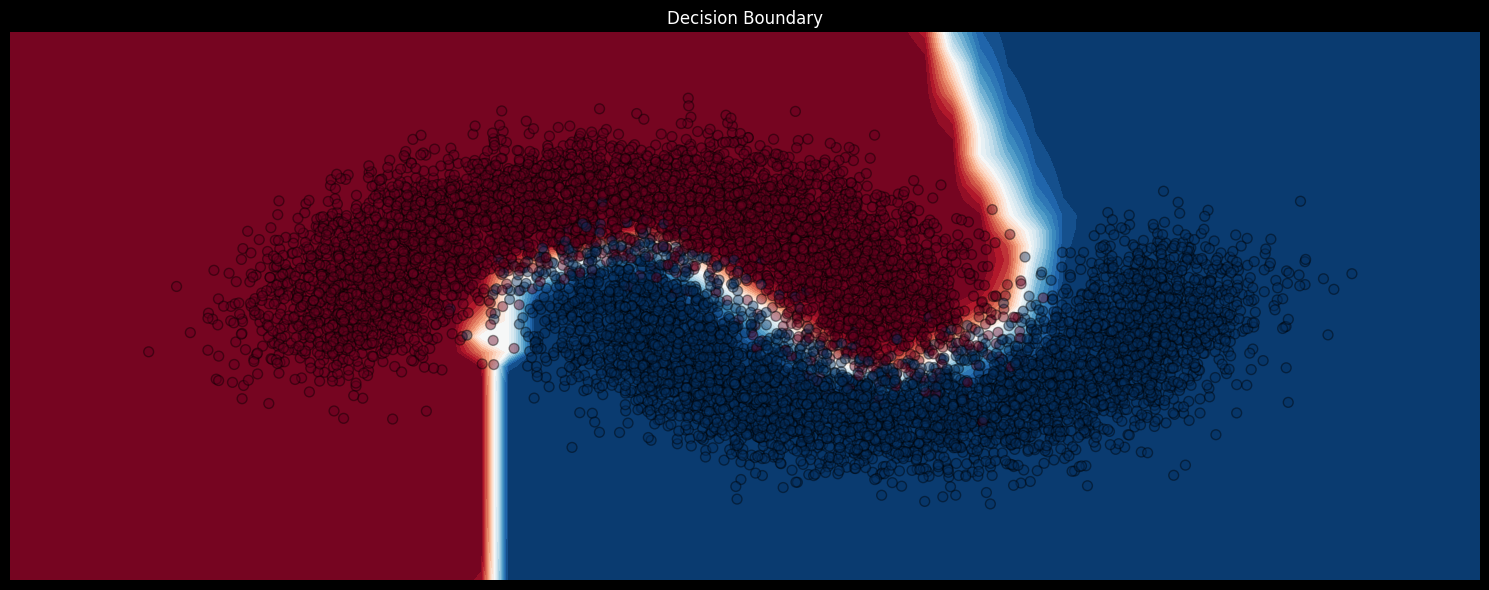

In [20]:
plot_decision_boundary(model)

**Поэкспеременитруем со случайным лесом и catboost**

In [21]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [22]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
scores_rf = cross_val_score(rf, X_train, y_train, cv=cv, scoring='accuracy')
y_pred_rf = rf.predict(X_val)
y_proba_rf = rf.predict_proba(X_val)[:, 1] # вероятности, это для ROC AUC

cb = CatBoostClassifier(verbose=0, iterations=100, learning_rate=.15)
cb.fit(X_train, y_train)
scores_cb = cross_val_score(cb, X_train, y_train, cv=cv, scoring='accuracy')
y_pred_cb = cb.predict(X_val)
y_proba_cb = cb.predict_proba(X_val)[:, 1] # вероятности, это для ROC AUC

print("===Random Forest===")
print(f"CV Accuracy: {scores_rf}")
print(f'Accuracy: {accuracy_score(y_val, y_pred_rf)}')
print(f'ROC AUC: {roc_auc_score(y_val, y_proba_rf)}')
print(classification_report(y_val, y_pred_rf))

print("\n===CatBoost===")
print(f"CV Accuracy: {scores_cb}")
print(f'Accuracy: {accuracy_score(y_val, y_pred_cb)}')
print(f'ROC AUC: {roc_auc_score(y_val, y_proba_cb)}')
print(classification_report(y_val, y_pred_cb))

===Random Forest===
CV Accuracy: [0.97071429 0.96071429 0.97285714 0.97142857 0.97      ]
Accuracy: 0.967
ROC AUC: 0.9922149595348679
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1539
           1       0.96      0.98      0.97      1461

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000


===CatBoost===
CV Accuracy: [0.975      0.96571429 0.975      0.97714286 0.97357143]
Accuracy: 0.9703333333333334
ROC AUC: 0.9958018287028698
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1539
           1       0.96      0.98      0.97      1461

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



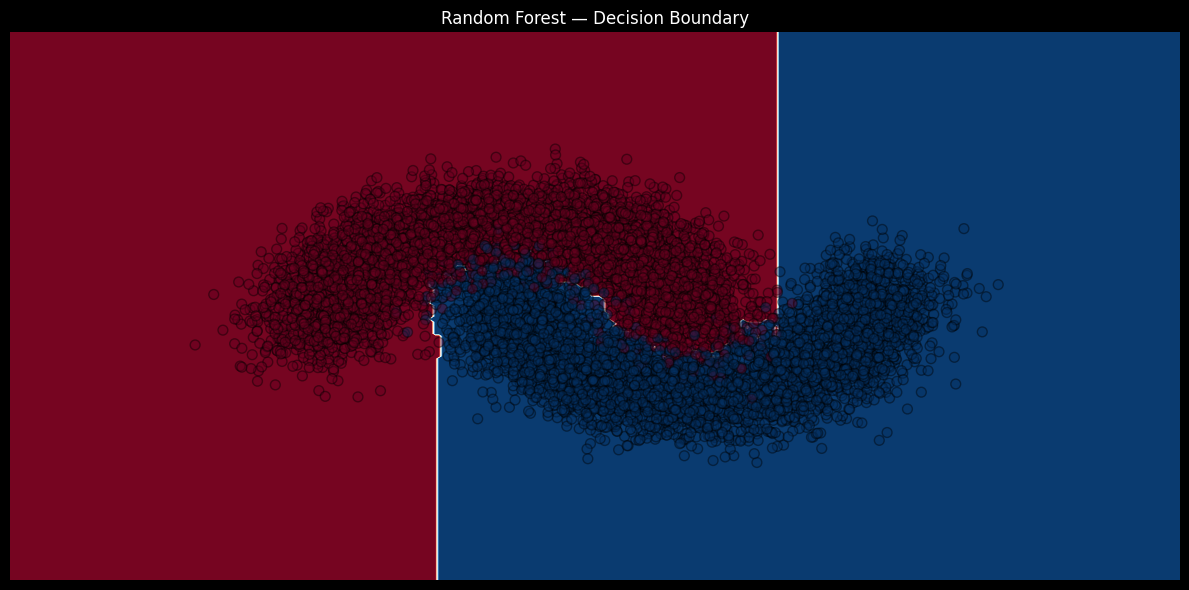

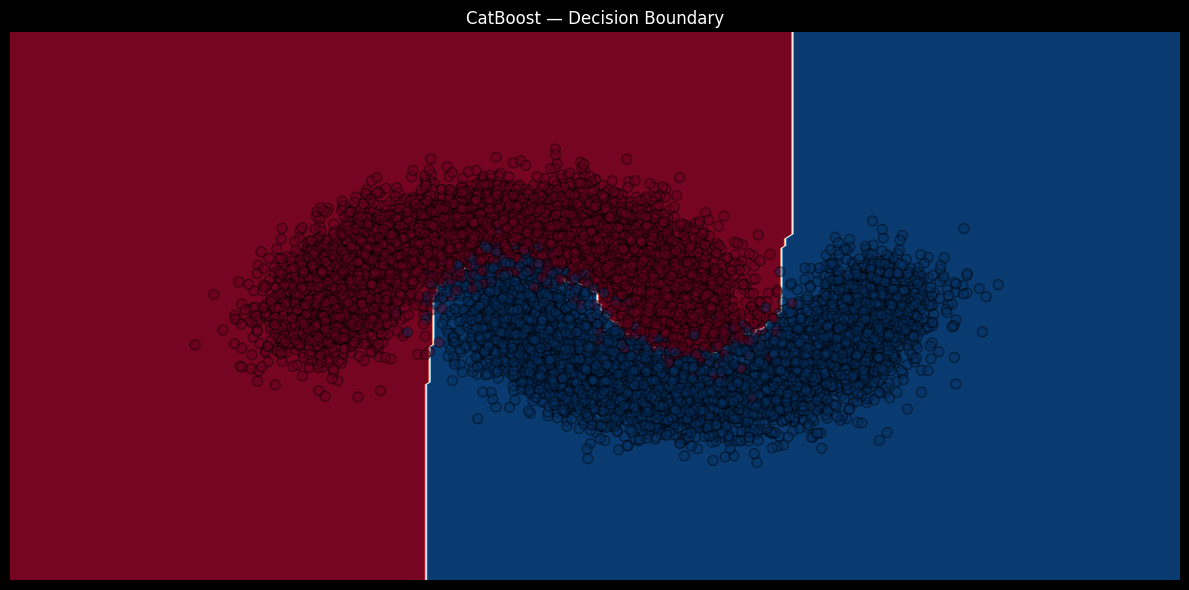

In [ ]:
def plot_decision_boundary_ML(model, X_all, y_all, title="Decision Boundary"):
    h = 0.02
    x_min, x_max = X_all[:, 0].min() - 1, X_all[:, 0].max() + 1
    y_min, y_max = X_all[:, 1].min() - 1, X_all[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    X_mesh = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(X_mesh).reshape(xx.shape)

    plt.figure(figsize=(12, 6))
    plt.contourf(xx, yy, Z, 25, cmap="RdBu", vmin=0, vmax=1)
    plt.scatter(X_all[:, 0], X_all[:, 1], c=y_all, cmap="RdBu", s=50, linewidth=1, alpha=.42, ec="black")
    plt.title(title)
    plt.grid(True)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Визуализация
plot_decision_boundary_ML(rf, X, y, title="Random Forest — Decision Boundary")
plot_decision_boundary_ML(cb, X, y, title="CatBoost — Decision Boundary")

**Лучшим вариантом оказалась модель CatBoost**

Теперь необходимо затюнить параметры, используя optuna.

Так модель станет еще лучше

In [24]:
import optuna
# Objective функция для optuna
def objective(trial):
    # Параметры, которые будет подбирать Optuna
    params = {
        'iterations': trial.suggest_int("iterations", 100, 1000), # итерации от 100 до 1000 - кол-во деревьев
        'depth': trial.suggest_int("depth", 3, 10), # глубина деревьев
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True), # скорость обучения
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10), # степень регуляризации
        "border_count": trial.suggest_int("border_count", 32, 255), # границы для числовых признаков
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10), # важность шума
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1), # случайность выборки
        "random_state": 42,
        "verbose": 0
    }
    model = CatBoostClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 15, timeout = 120) # 15 попыток и 2 минуты
print("Best params: ", study.best_params)
print("Best Accuracy: ", study.best_value)

[I 2025-06-25 16:07:54,415] A new study created in memory with name: no-name-4f9da444-ed63-46eb-868b-d3bcc487f2d0
[I 2025-06-25 16:08:00,374] Trial 0 finished with value: 0.945857142857143 and parameters: {'iterations': 921, 'depth': 3, 'learning_rate': 0.0013409814662517128, 'l2_leaf_reg': 5.8148695636247565, 'border_count': 214, 'random_strength': 3.611343097715053, 'bagging_temperature': 0.6309370458111352}. Best is trial 0 with value: 0.945857142857143.
[I 2025-06-25 16:08:02,348] Trial 1 finished with value: 0.974 and parameters: {'iterations': 301, 'depth': 3, 'learning_rate': 0.04633993838575817, 'l2_leaf_reg': 9.006854429362159, 'border_count': 57, 'random_strength': 1.6902621761438121, 'bagging_temperature': 0.2624668167061034}. Best is trial 1 with value: 0.974.
[I 2025-06-25 16:08:09,850] Trial 2 finished with value: 0.974 and parameters: {'iterations': 776, 'depth': 6, 'learning_rate': 0.019247290431106876, 'l2_leaf_reg': 9.345718225645733, 'border_count': 245, 'random_stre

Best params:  {'iterations': 420, 'depth': 5, 'learning_rate': 0.014848716441707054, 'l2_leaf_reg': 8.1326936861626, 'border_count': 253, 'random_strength': 2.252806587822259, 'bagging_temperature': 0.7884745570461342}
Best Accuracy:  0.9741428571428571


In [25]:
best_params = study.best_params
best_params["random_state"] = 42
best_params['verbose'] = 0

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_val)
y_proba = best_model.predict_proba(X_val)[:, 1]
print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'ROC AUC: {roc_auc_score(y_val, y_proba)}')

Accuracy: 0.9713333333333334
ROC AUC: 0.9960824628560017


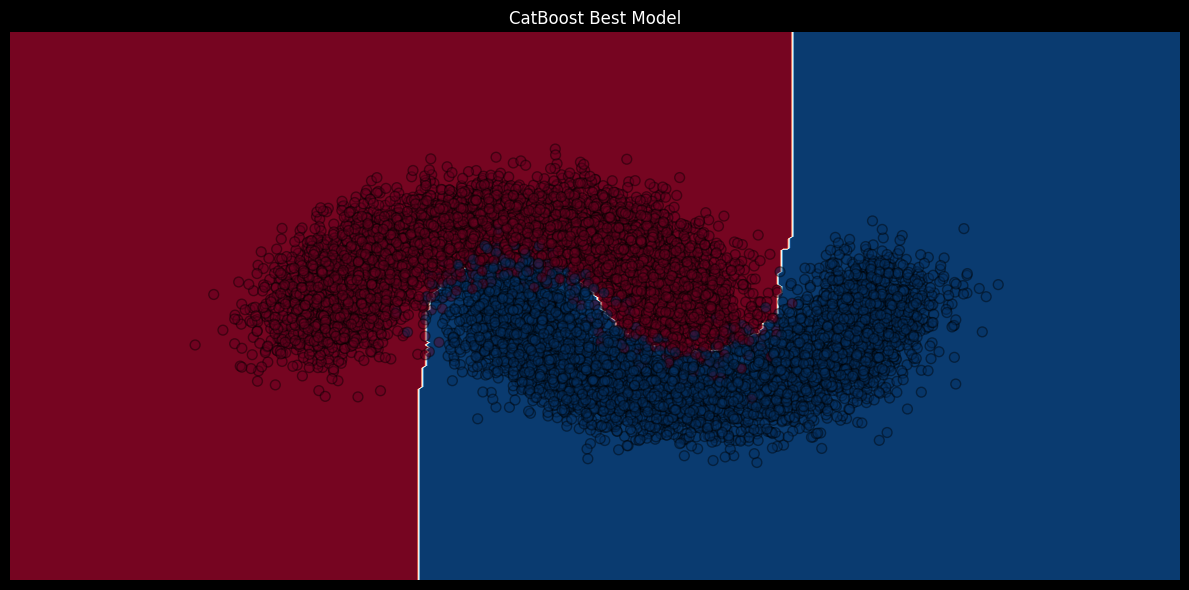

In [26]:
plot_decision_boundary_ML(best_model, X, y, title="CatBoost Best Model")